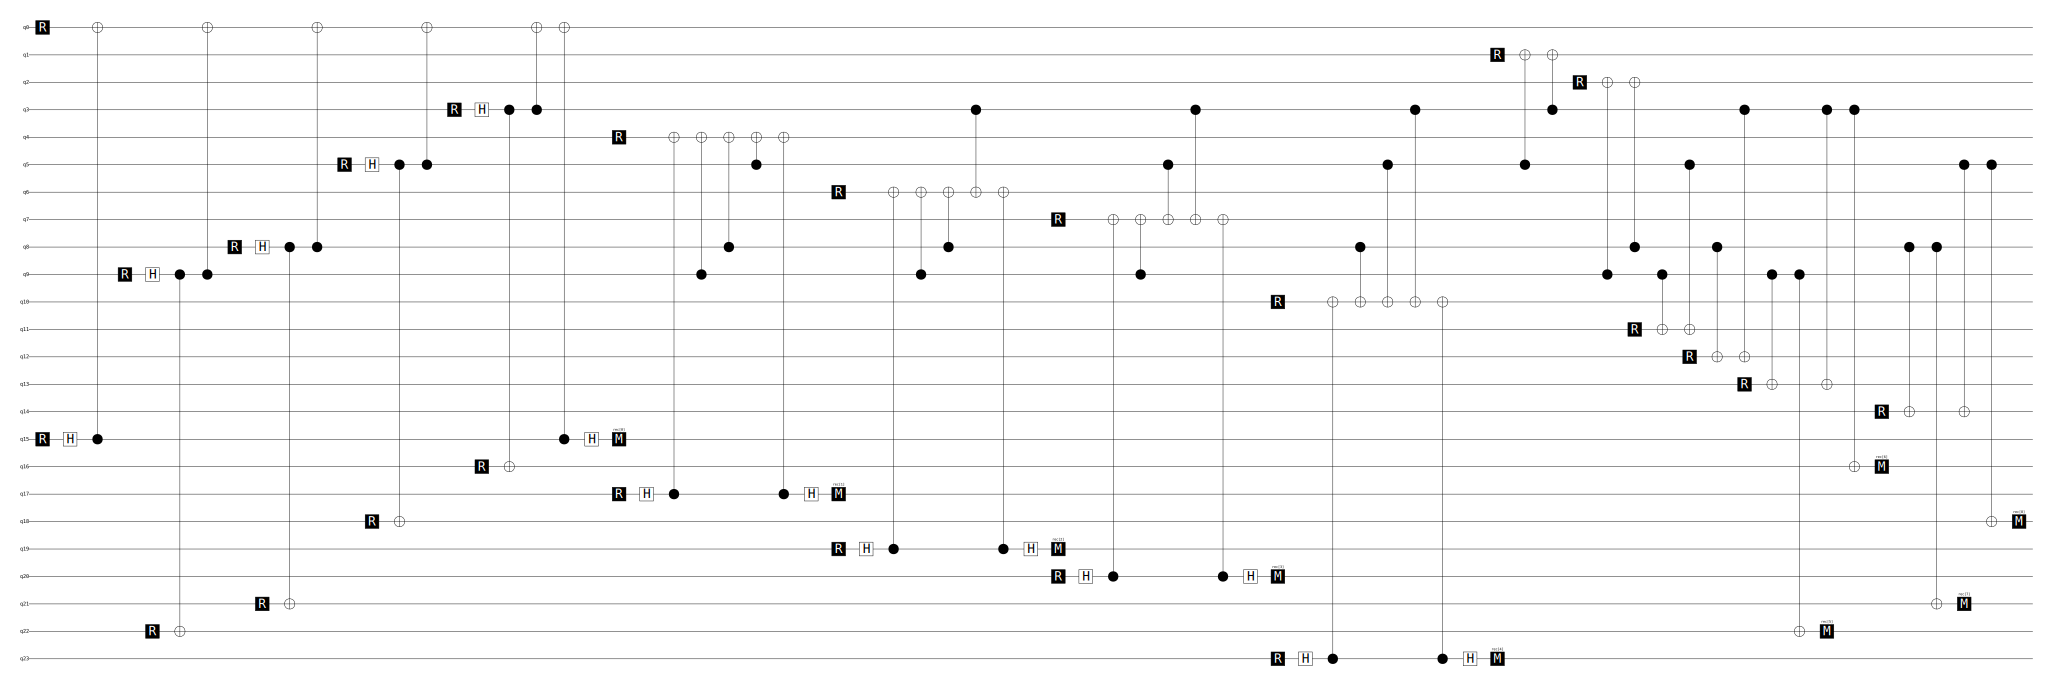

In [28]:
import stabgraph as stg
import flag_stitcher
import stim
import numpy as np

stabs_15_7_3 = [
    'ZIZIZIZIZIZIZIZ',
    'IZZIIZZIIZZIIZZ',
    'IIIZZZZIIIIZZZZ',
    'IIIIIIIZZZZZZZZ',
    'XIXIXIXIXIXIXIX',
    'IXXIIXXIIXXIIXX',
    'IIIXXXXIIIIXXXX',
    'IIIIIIIXXXXXXXX',
    'IIZIIIZIIIZIIIZ',
    'IIIIIIIIIIIZZZZ',
    'IIIIZIZIIIIIZIZ',
    'IIIIIIIIIZZIIZZ',
    'IIIIIIIIZIZIZIZ',
    'IIIIIZZIIIIIIZZ',
    'ZZZZZZZZZZZZZZZ'
]
H_x_15_7_3 = H_z_15_7_3 = np.array([
    [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
])
L_x_15_7_3 = L_z_15_7_3 = np.array([
    [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
])

distance=3
G,c,t,_,_=stg.convert(stabs_15_7_3, shuffle=True)
operations = flag_stitcher.build_ft_circuit(G,c,t,distance)

def FAO_to_stim_circuiut(operations: list[tuple[str, list]]):
    circ = stim.Circuit()
    for o, i in operations:
        circ.append(o, i)
    return circ

c = FAO_to_stim_circuiut(operations)
c.diagram('timeline-svg')

In [35]:
from pprint import pprint
from tqdm import tqdm

type_to_stim = {
    "X": stim.target_x,
    "Y": stim.target_y,
    "Z": stim.target_z,
}
possible_errors = [
    "XI", "ZI", #"YZ",
    "IX", "XX", "ZX", #"YX",
    "IZ", "XZ", "ZZ", #"YI",
    #"IY", "XY", "ZY", "YY",
]

def FAO_to_faulty_circuiut(operations: list[tuple[str, list]], error_index: int, error_type: str):
    circ = stim.Circuit()
    k = 0
    for op, qubits in operations:
        circ.append(op, qubits)
        if op == "CNOT":
            k += 1
        if k == error_index:
            circ.append(
                "CORRELATED_ERROR",
                [type_to_stim[t](q) for t, q in zip(error_type, qubits) if t != "I"],
                1
            )
            k += 2
    return circ

def num_cnots(ops: list[tuple[str, list]]):
    return sum(1 for op, _ in ops if op == "CNOT")
def num_measurements(ops: list[tuple[str, list]]):
    return sum(1 for op, _ in ops if op == "M")


error_to_syndrome_z = {}
error_to_syndrome_x = {}
error_to_syndrome = {}
flags_to_syndrome = {}
candiadate = L_x_15_7_3[0]

n_falgs = num_measurements(operations)
for i in tqdm(range(num_cnots(operations))):
    for error_type in possible_errors:
        circ = FAO_to_faulty_circuiut(operations, i + 1, error_type)
        circ.append("M", range(15))
        ts = stim.TableauSimulator()
        ts.do(circ)
        s = ts.current_measurement_record()
        flags = tuple(int(k) for k in s[:-15])
        measurements = s[-15:]
        z_syndrome_1 = tuple((H_x_15_7_3 @ measurements % 2).tolist())
        z_syndrome_2 = tuple((L_x_15_7_3 @ measurements % 2).tolist())
        error_to_syndrome_z[(i, error_type)] = (z_syndrome_1, z_syndrome_2)
        error_to_syndrome_z[flags] = (z_syndrome_1, z_syndrome_2)

        circ = FAO_to_faulty_circuiut(operations, i + 1, error_type)
        circ.append("H", range(15))
        circ.append("M", range(15))
        ts = stim.TableauSimulator()
        ts.do(circ)
        s = ts.current_measurement_record()
        flags = tuple(int(k) for k in s[:-15])
        measurements = s[-15:]
        x_syndrome_1 = tuple((H_x_15_7_3 @ measurements % 2).tolist())
        x_syndrome_2 = tuple((L_x_15_7_3 @ measurements % 2).tolist())
        error_to_syndrome_x[(i, error_type)] = (x_syndrome_1, x_syndrome_2)
        error_to_syndrome_x[flags] = (x_syndrome_1, x_syndrome_2)

        error_to_syndrome[(i, error_type)] = ((z_syndrome_1, z_syndrome_2), (x_syndrome_1, x_syndrome_2))
        flags_to_syndrome[flags] = ((z_syndrome_1, z_syndrome_2), (x_syndrome_1, x_syndrome_2))

pprint(error_to_syndrome)

100%|██████████| 46/46 [00:32<00:00,  1.44it/s]

{(0, 'IX'): (((1, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1)),
             ((0, 0, 0, 0), (1, 1, 1, 1, 0, 1, 1))),
 (0, 'IZ'): (((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
             ((0, 0, 0, 0), (0, 1, 0, 0, 1, 0, 1))),
 (0, 'XI'): (((1, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1)),
             ((0, 0, 0, 0), (0, 0, 1, 1, 0, 0, 0))),
 (0, 'XX'): (((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
             ((0, 0, 0, 0), (1, 1, 0, 0, 1, 0, 1))),
 (0, 'XZ'): (((1, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1)),
             ((0, 0, 0, 0), (0, 0, 1, 1, 0, 0, 1))),
 (0, 'ZI'): (((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
             ((0, 0, 0, 0), (1, 0, 0, 1, 1, 0, 1))),
 (0, 'ZX'): (((1, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1)),
             ((0, 0, 0, 0), (1, 0, 0, 0, 0, 0, 1))),
 (0, 'ZZ'): (((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
             ((0, 0, 0, 0), (0, 1, 0, 1, 1, 1, 1))),
 (1, 'IX'): (((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
             ((0, 0, 0, 0), (1, 1, 1, 1, 0, 0, 1))),
 (1, 'IZ'): (((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
   

In [77]:
code_capacity_1_z = {}
code_capacity_1_x = {}

circ = FAO_to_stim_circuiut(operations)

for error_location in range(15):
    for (error_type, measurement_basis) in [('Z','X'), ('X','Z')]:
        ts = stim.TableauSimulator()
        ts.do(circ)
        if error_type == "Z":
            ts.z(error_location)
        else:
            ts.x(error_location)
        if measurement_basis == "X":
            ts.h(*range(15))
        ts.measure_many(*range(15))
        measurements = ts.current_measurement_record()[-15:]
        x_syndrome_1 = tuple((H_x_15_7_3 @ measurements % 2).tolist())
        x_syndrome_2 = tuple((L_x_15_7_3 @ measurements % 2).tolist())
        if measurement_basis == "X":
            code_capacity_1_x[(error_location, error_type)] = (x_syndrome_1, x_syndrome_2)
        else:
            code_capacity_1_z[(error_location, error_type)] = (x_syndrome_1, x_syndrome_2)

# pprint(code_capacity_1_x)
pprint(code_capacity_1_z)


{(0, 'X'): ((1, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1)),
 (1, 'X'): ((0, 1, 0, 0), (0, 0, 0, 0, 0, 0, 1)),
 (2, 'X'): ((1, 1, 0, 0), (1, 0, 0, 0, 0, 0, 1)),
 (3, 'X'): ((0, 0, 1, 0), (0, 0, 0, 0, 0, 0, 1)),
 (4, 'X'): ((1, 0, 1, 0), (0, 0, 1, 0, 0, 0, 1)),
 (5, 'X'): ((0, 1, 1, 0), (0, 0, 0, 0, 0, 1, 1)),
 (6, 'X'): ((1, 1, 1, 0), (1, 0, 1, 0, 0, 1, 1)),
 (7, 'X'): ((0, 0, 0, 1), (0, 0, 0, 0, 0, 0, 1)),
 (8, 'X'): ((1, 0, 0, 1), (0, 0, 0, 0, 1, 0, 1)),
 (9, 'X'): ((0, 1, 0, 1), (0, 0, 0, 1, 0, 0, 1)),
 (10, 'X'): ((1, 1, 0, 1), (1, 0, 0, 1, 1, 0, 1)),
 (11, 'X'): ((0, 0, 1, 1), (0, 1, 0, 0, 0, 0, 1)),
 (12, 'X'): ((1, 0, 1, 1), (0, 1, 1, 0, 1, 0, 1)),
 (13, 'X'): ((0, 1, 1, 1), (0, 1, 0, 1, 0, 1, 1)),
 (14, 'X'): ((1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1))}


In [50]:
syndrome_to_x_error = {}
for error, syndromes in code_capacity_1_z.items():
    syndrome_to_x_error[syndromes] = error
# del syndrome_to_x_error[((0, 0, 0, 0), (0, 0, 0, 0, 0, 0))]

syndrome_to_z_error = {}
for error, syndromes in code_capacity_1_x.items():
    syndrome_to_z_error[syndromes] = error
# del syndrome_to_z_error[((0, 0, 0, 0), (0, 0, 0, 0, 0, 0))]

pprint(code_capacity_1_z)
pprint(code_capacity_1_x)

{(0, 'X'): ((1, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1)),
 (0, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
 (1, 'X'): ((0, 1, 0, 0), (0, 0, 0, 0, 0, 0, 1)),
 (1, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
 (2, 'X'): ((1, 1, 0, 0), (1, 0, 0, 0, 0, 0, 1)),
 (2, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
 (3, 'X'): ((0, 0, 1, 0), (0, 0, 0, 0, 0, 0, 1)),
 (3, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
 (4, 'X'): ((1, 0, 1, 0), (0, 0, 1, 0, 0, 0, 1)),
 (4, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
 (5, 'X'): ((0, 1, 1, 0), (0, 0, 0, 0, 0, 1, 1)),
 (5, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
 (6, 'X'): ((1, 1, 1, 0), (1, 0, 1, 0, 0, 1, 1)),
 (6, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
 (7, 'X'): ((0, 0, 0, 1), (0, 0, 0, 0, 0, 0, 1)),
 (7, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
 (8, 'X'): ((1, 0, 0, 1), (0, 0, 0, 0, 1, 0, 1)),
 (8, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
 (9, 'X'): ((0, 1, 0, 1), (0, 0, 0, 1, 0, 0, 1)),
 (9, 'Z'): ((0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0)),
